In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [7]:
import os
print(os.getcwd())

c:\Users\Sk Arbaaz Mehamood\AppData\Local\Programs\Microsoft VS Code


In [8]:
# Load dataset
df = pd.read_csv("Sample - Superstore.csv", encoding="latin1")

# Convert date column
df["Order Date"] = pd.to_datetime(df["Order Date"])

# Sort values
df = df.sort_values("Order Date")

df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
7980,7981,CA-2014-103800,2014-01-03,1/7/2014,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,...,77095,Central,OFF-PA-10000174,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448,2,0.2,5.5512
739,740,CA-2014-112326,2014-01-04,1/8/2014,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,60540,Central,OFF-LA-10003223,Office Supplies,Labels,Avery 508,11.784,3,0.2,4.2717
740,741,CA-2014-112326,2014-01-04,1/8/2014,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,60540,Central,OFF-ST-10002743,Office Supplies,Storage,SAFCO Boltless Steel Shelving,272.736,3,0.2,-64.7748
741,742,CA-2014-112326,2014-01-04,1/8/2014,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,60540,Central,OFF-BI-10004094,Office Supplies,Binders,GBC Standard Plastic Binding Systems Combs,3.540,2,0.8,-5.4870
1759,1760,CA-2014-141817,2014-01-05,1/12/2014,Standard Class,MB-18085,Mick Brown,Consumer,United States,Philadelphia,...,19143,East,OFF-AR-10003478,Office Supplies,Art,Avery Hi-Liter EverBold Pen Style Fluorescent ...,19.536,3,0.2,4.8840


In [10]:
# Aggregate daily sales
daily_sales = df.groupby("Order Date")["Sales"].sum().reset_index()

daily_sales = daily_sales.sort_values("Order Date")

daily_sales.head()

,Order Date,Sales
0,2014-01-03,16.448
1,2014-01-04,288.060
2,2014-01-05,19.536
3,2014-01-06,4407.100
4,2014-01-07,87.158


In [11]:
# Time features
daily_sales["Year"] = daily_sales["Order Date"].dt.year
daily_sales["Month"] = daily_sales["Order Date"].dt.month
daily_sales["Day"] = daily_sales["Order Date"].dt.day
daily_sales["DayOfWeek"] = daily_sales["Order Date"].dt.dayofweek
daily_sales["WeekOfYear"] = daily_sales["Order Date"].dt.isocalendar().week.astype(int)

# Lag features
daily_sales["Lag_1"] = daily_sales["Sales"].shift(1)
daily_sales["Lag_7"] = daily_sales["Sales"].shift(7)
daily_sales["Lag_30"] = daily_sales["Sales"].shift(30)

# Remove missing values
daily_sales = daily_sales.dropna()

daily_sales.head()

,Order Date,Sales,Year,Month,Day,DayOfWeek,WeekOfYear,Lag_1,Lag_7,Lag_30
30,2014-02-12,129.568,2014,2,12,2,7,2043.400,211.646,16.448
31,2014-02-14,576.726,2014,2,14,4,7,129.568,97.112,288.060
32,2014-02-15,21.360,2014,2,15,5,7,576.726,134.384,19.536
33,2014-02-16,9.040,2014,2,16,6,7,21.360,330.512,4407.100
34,2014-02-17,54.208,2014,2,17,0,8,9.040,180.320,87.158


In [12]:
# Log transform target
daily_sales["Sales_log"] = np.log1p(daily_sales["Sales"])

In [13]:
features = [
    "Year",
    "Month",
    "Day",
    "DayOfWeek",
    "WeekOfYear",
    "Lag_1",
    "Lag_7",
    "Lag_30"
]

X = daily_sales[features]

y = daily_sales["Sales_log"]

In [14]:
split = int(len(daily_sales) * 0.8)

X_train = X[:split]
X_test = X[split:]

y_train = y[:split]
y_test = y[split:]

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

Training samples: 965
Testing samples: 242


In [15]:
lr_model = LinearRegression()

lr_model.fit(X_train, y_train)

lr_pred_log = lr_model.predict(X_test)

lr_pred = np.expm1(lr_pred_log)

actual = np.expm1(y_test)

In [18]:
# Linear Regression metrics
lr_mae = mean_absolute_error(actual, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(actual, lr_pred))
lr_smape = smape(actual, lr_pred)


### random forest regressor

In [16]:
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

rf_pred_log = rf_model.predict(X_test)

rf_pred = np.expm1(rf_pred_log)

In [19]:
# Random Forest metrics
rf_mae = mean_absolute_error(actual, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(actual, rf_pred))
rf_smape = smape(actual, rf_pred)

In [17]:
def smape(actual, predicted):
    
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    return np.mean(
        2 * np.abs(predicted - actual) /
        (np.abs(actual) + np.abs(predicted))
    ) * 100

In [20]:
# Comparison table
comparison = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "MAE": [lr_mae, rf_mae],
    "RMSE": [lr_rmse, rf_rmse],
    "SMAPE (%)": [lr_smape, rf_smape]
})

comparison

,Model,MAE,RMSE,SMAPE (%)
0,Linear Regression,1684.273403,2561.206603,79.479351
1,Random Forest,1732.412308,2766.031466,83.754290


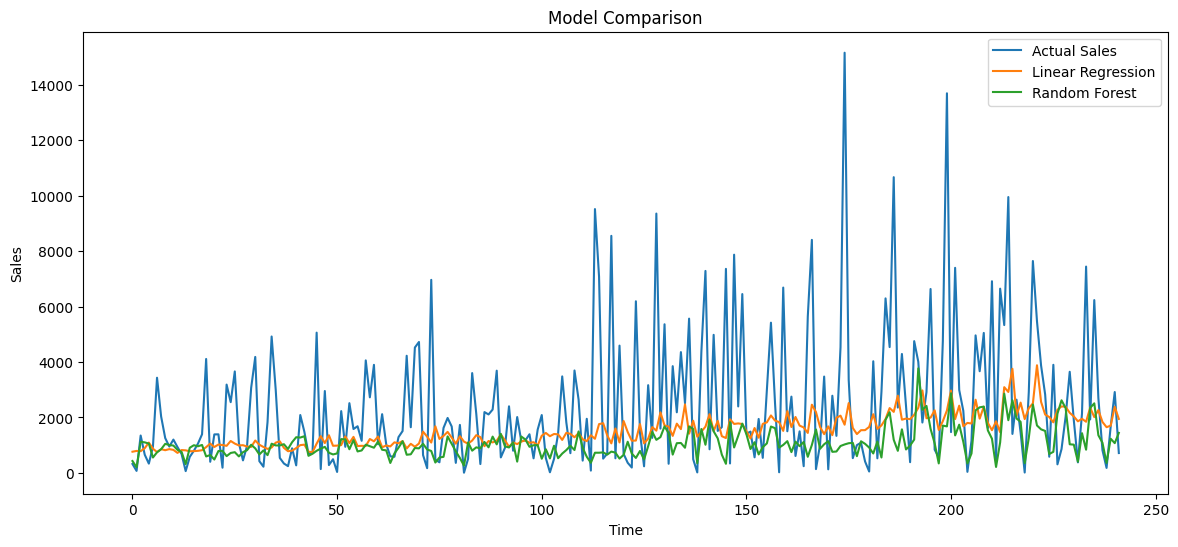

In [21]:
plt.figure(figsize=(14,6))

plt.plot(actual.values, label="Actual Sales")

plt.plot(lr_pred, label="Linear Regression")

plt.plot(rf_pred, label="Random Forest")

plt.title("Model Comparison")

plt.xlabel("Time")

plt.ylabel("Sales")

plt.legend()

plt.show()


In [22]:
future = daily_sales.copy()

future_predictions = []

for i in range(30):
    
    last_row = future.iloc[-1]
    
    next_date = last_row["Order Date"] + pd.Timedelta(days=1)
    
    new_row = {
        "Order Date": next_date,
        "Year": next_date.year,
        "Month": next_date.month,
        "Day": next_date.day,
        "DayOfWeek": next_date.dayofweek,
        "WeekOfYear": next_date.isocalendar().week,
        "Lag_1": last_row["Sales"],
        "Lag_7": future.iloc[-7]["Sales"],
        "Lag_30": future.iloc[-30]["Sales"]
    }
    
    X_new = pd.DataFrame([new_row])[features]
    
    pred_log = rf_model.predict(X_new)
    
    pred = np.expm1(pred_log)[0]
    
    new_row["Sales"] = pred
    
    future = pd.concat([future, pd.DataFrame([new_row])])
    
    future_predictions.append(pred)

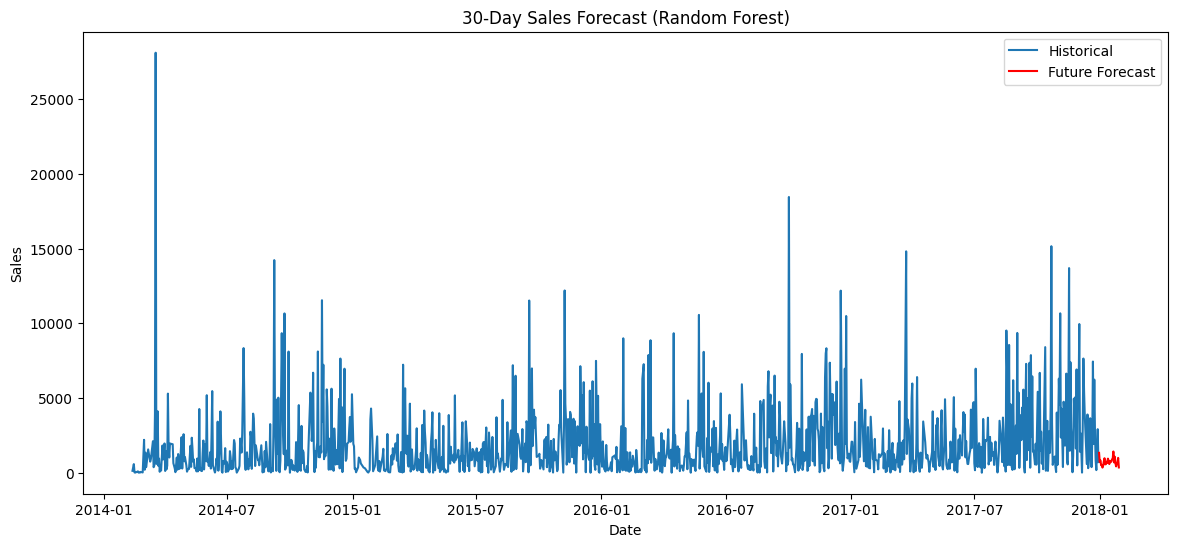

In [24]:
future_dates = pd.date_range(
    start=daily_sales["Order Date"].max() + pd.Timedelta(days=1),
    periods=30
)

plt.figure(figsize=(14,6))

plt.plot(daily_sales["Order Date"], daily_sales["Sales"], label="Historical")

plt.plot(future_dates, future_predictions, label="Future Forecast", color="red")

plt.title("30-Day Sales Forecast (Random Forest)")

plt.xlabel("Date")

plt.ylabel("Sales")

plt.legend()

plt.show()


In [25]:
print("Random Forest SMAPE:", round(rf_smape,2), "%")

print("\nConclusion:")
print("Random Forest performed better than Linear Regression.")
print("This model can help businesses plan inventory, staffing, and revenue.")

Random Forest SMAPE: 83.75 %

Conclusion:
Random Forest performed better than Linear Regression.
This model can help businesses plan inventory, staffing, and revenue.


In [26]:
plt.savefig("forecast.png")

<Figure size 640x480 with 0 Axes>